# AI Masters 2024, DL course, HW-4

## Building a Convolutional Recurrent Neural Network for License Plate Recognition task.

## 0. Примаунчиваем гугл-диск, извлекаем данные в `/content/data/`

In [1]:
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
if IN_COLAB:
    google.colab.drive.mount("/content/drive")

    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/MyDrive/ML3_2024/HW4")

    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"

    import sys
    sys.path.append(str(AUX_DATA_ROOT))
else:
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/kaggle/working")

Mounted at /content/drive


In [2]:
import os
import shutil
import zipfile

def unzip_dataset(path, zip_file_name='ai-masters-2024-hw-4-license-plate-recognition'):
    zip_file_path = os.path.join(path, zip_file_name + '.zip')

    if not os.path.exists(zip_file_path):
        print("Dataset doesn't exist or is broken, please download it to your Google Drive")
        return None, None

    content_path = '/content/' + zip_file_name + '.zip'

    shutil.copy(zip_file_path, content_path)
    print(f"File copied to /content/ as {zip_file_name}.zip")

    content_extract_to = '/content/data/'
    if not os.path.exists(content_extract_to):
        os.makedirs(content_extract_to)

    with zipfile.ZipFile(content_path, 'r') as archive:
        archive.extractall(content_extract_to)
    print(f"Dataset extracted to {content_extract_to}")

    path_to_train = os.path.join(content_extract_to, 'train')
    path_to_test = os.path.join(content_extract_to, 'test')

    def move_files_from_subfolders(src_dir, dest_dir):
        for item in os.listdir(src_dir):
            s = os.path.join(src_dir, item)
            d = os.path.join(dest_dir, item)

            if os.path.isdir(s):
                move_files_from_subfolders(s, dest_dir)
                os.rmdir(s)
            else:
                shutil.move(s, d)

        print(f"Moved files from {src_dir} to {dest_dir} and removed the empty folder.")

    move_files_from_subfolders(path_to_train, path_to_train)
    move_files_from_subfolders(path_to_test, path_to_test)

    return path_to_train, path_to_test

In [3]:
PATH_TO_TRAIN, PATH_TO_TEST = unzip_dataset(AUX_DATA_ROOT)

File copied to /content/ as ai-masters-2024-hw-4-license-plate-recognition.zip
Dataset extracted to /content/data/
Moved files from /content/data/train/train/simple to /content/data/train and removed the empty folder.
Moved files from /content/data/train/train/complex to /content/data/train and removed the empty folder.
Moved files from /content/data/train/train to /content/data/train and removed the empty folder.
Moved files from /content/data/train to /content/data/train and removed the empty folder.
Moved files from /content/data/test/result to /content/data/test and removed the empty folder.
Moved files from /content/data/test to /content/data/test and removed the empty folder.


## 1. Делаем все необходимые импорты и установку seed.

In [4]:
def set_global_seed(seed: int) -> None:
    """
    Set global seed for reproducibility.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [5]:
!pip install --upgrade albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


In [6]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.4 MB/s eta 0:00:00


In [7]:
import torchvision.transforms as transforms
import torchvision.datasets   as datasets
import torch.nn.functional    as F
import torchvision.models     as models

import matplotlib.pyplot      as plt
import torch.optim            as optim
import torch.nn               as nn

import torchvision
import colorsys
import random
import torch
import json
import time
import tqdm
import cv2
import os
import rapidfuzz

from torch.nn           import init
from torch.nn           import Module, GRU, LSTM, Sequential, Conv2d, Linear

from torchvision.transforms.v2         import Resize, ToDtype, ToImage, Normalize, Compose, ToTensor
from torchvision.transforms.functional import convert_image_dtype, resize, to_pil_image
from torch.nn.functional import log_softmax, ctc_loss
from torch.utils.data    import Dataset, DataLoader
from collections         import namedtuple
from matplotlib.patches  import Polygon
from matplotlib          import patches, lines
from PIL                 import Image

from torchvision.io import read_image
from string import digits, ascii_uppercase

import albumentations as alb
import numpy          as np
import scipy          as sp

import warnings
warnings.filterwarnings('ignore')

set_global_seed(42)

## 2. Подготовим Dataset и Dataloader и посмотрим на данные.

### Dataset

In [8]:
train_imgs = []

for img in os.listdir(PATH_TO_TRAIN):
    train_imgs.append({"file": os.path.join(PATH_TO_TRAIN, img),
                       "text": img[-12:-4] if img[-13] == '_' else img [-13:-4]})

In [9]:
def display_random_images(config, sample_size=15, num_cols=5):
    num_rows = sample_size // num_cols + int(sample_size % num_cols != 0)

    random_idxs = np.random.choice(len(train_imgs), size=sample_size, replace=False)
    plt.figure(figsize=(20, 2 * num_rows))

    for i, idx in enumerate(random_idxs, 1):
        item = train_imgs[idx]
        text = item["text"]
        image = cv2.imread(item["file"])

        plt.subplot(num_rows, num_cols, i)
        plt.imshow(image[:, :, ::-1]) # BGR -> RGB
        plt.title(text)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

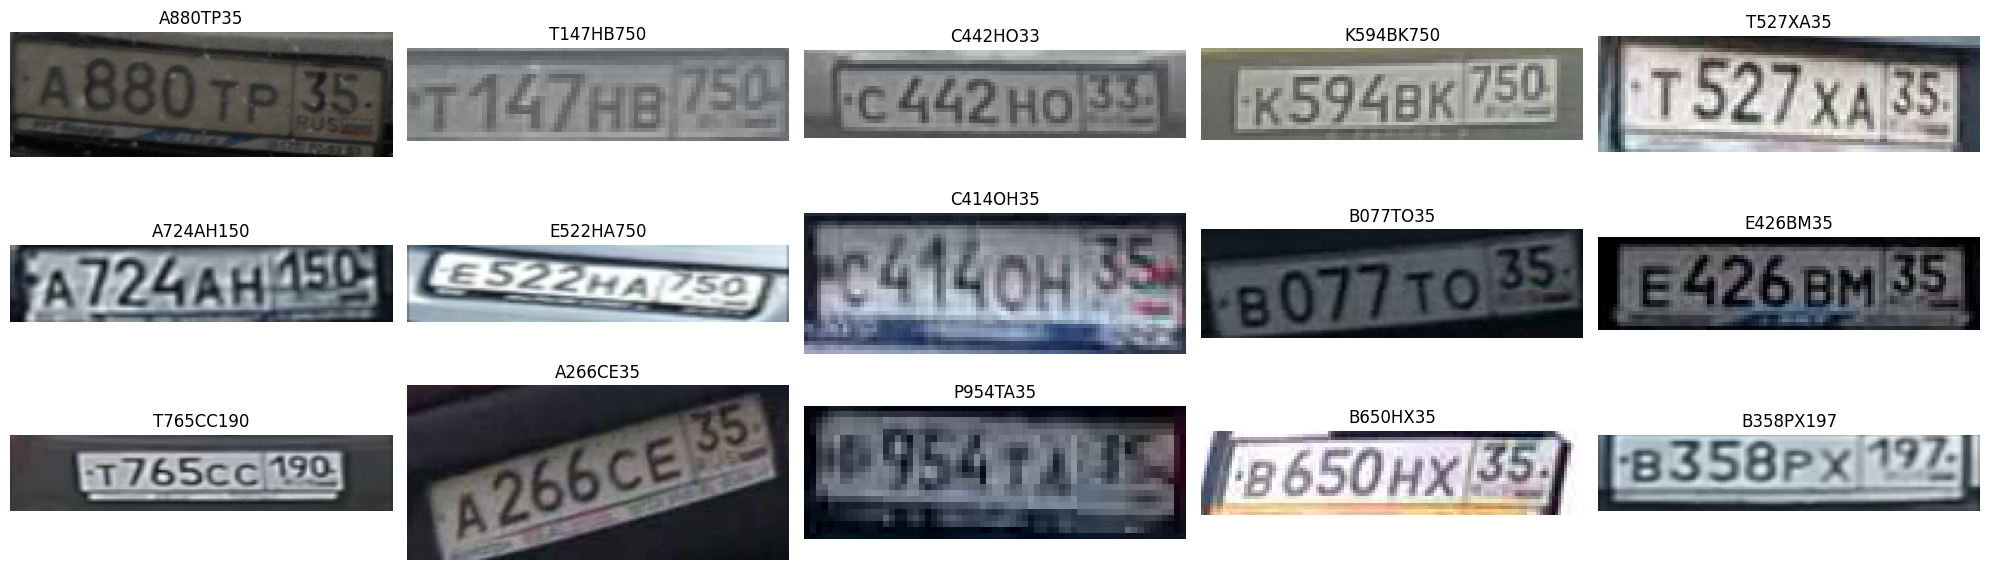

In [10]:
display_random_images(train_imgs)

In [11]:
abc = "0123456789ABEKMHOPCTYX"

def compute_mask(text):
    """Compute letter-digit mask of text, e.g. 'E506EC152' -> 'LDDDLLDDD'.

    Args:
        - text: String of text.

    Returns:
        String of the same length but with every letter replaced by 'L' and every digit replaced by 'D'
        or None if non-letter and non-digit character met in text.
    """
    mask = []

    # YOUR CODE HERE
    for char in text:
        if char in digits:
            mask.append("D")
        elif char in ascii_uppercase:
            mask.append("L")
        else:
            return None
    # END OF YOUR CODE

    return "".join(mask)

def check_in_alphabet(text, alphabet=abc):
    """Check if all chars in text come from alphabet.

    Args:
        - text: String of text.
        - alphabet: String of alphabet.

    Returns:
        True if all chars in text are from alphabet and False otherwise.
    """

    # YOUR CODE HERE
    for char in text:
        if char not in alphabet:
            return False
    # END OF YOUR CODE

    return True

def filter_data(config):
    """Filter config items keeping only ones with correct text.

    Args:
        - config: List of dicts, each dict having keys "file" and "text".

    Returns:
        Filtered list (config subset).
    """
    config_filtered = []
    for item in tqdm.tqdm(config):
        text = item["text"]
        mask = compute_mask(text)
        if check_in_alphabet(text) and (mask == "LDDDLLDD" or mask == "LDDDLLDDD"):
            config_filtered.append({"file": item["file"], "text": item["text"]})
    return config_filtered

In [12]:
train_imgs = filter_data(train_imgs)

100%|██████████| 24546/24546 [00:00<00:00, 212416.05it/s]


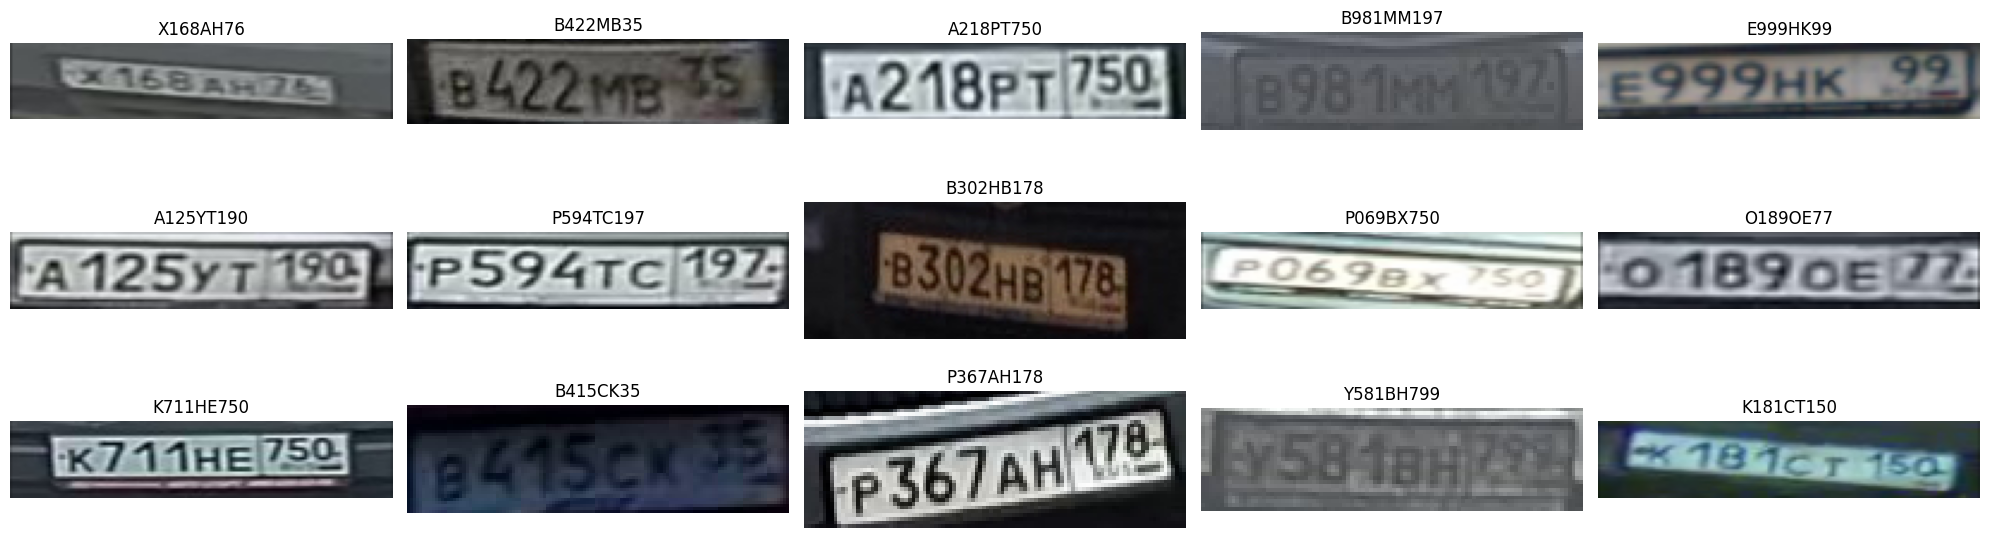

In [13]:
display_random_images(train_imgs)

In [14]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, config, alphabet=abc, transforms=None):
        """Constructor for class.

        Args:
            - config: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.config                  = config
        self.alphabet                = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms              = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.config:
            image_name = item["file"]
            text = item['text']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "torch_image", "pil_image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """
        pil_image   = Image.open(self.image_names[item])
        if pil_image.mode != 'RGB':
            pil_image = pil_image.convert('RGB')
        torch_image = self.transforms(pil_image)

        text    = self.texts[item]
        seq     = self.text_to_seq(text)
        seq_len = len(seq)
        output  = dict(torch_image=torch_image, pil_image=pil_image, seq=seq, seq_len=seq_len, text=text)

        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.

        Args:
            - String of text.

        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """

        # YOUR CODE HERE
        seq = [self.alphabet.find(c) + 1 for c in text]
        # END OF YOUR CODE

        return seq

In [15]:
transforms = Compose([
    ToImage(), ToDtype(torch.float32, scale=True), Resize(size=(32,160)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = RecognitionDataset(train_imgs, alphabet=abc, transforms=transforms)

In [16]:
x = dataset[0]
print(x.keys())

dict_keys(['torch_image', 'pil_image', 'seq', 'seq_len', 'text'])


In [17]:
from torchvision.transforms.functional import to_pil_image
print("Image shape:", x["torch_image"].shape)
print("Seq:" , x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])

Image shape: torch.Size([3, 32, 160])
Seq: [12, 4, 7, 7, 11, 19, 4, 6] Seq_len: 8
Text: B366AC35


### Dataloader

In [18]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.

    Args:
        - batch: List of dataset __getitem__ return values (dicts).

    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    torch_images, pil_images, seqs, seq_lens, texts = [], [], [], [], []
    # YOUR CODE HERE
    for item in batch:
        torch_images.append(item["torch_image"] )
        pil_images  .append(item["pil_image"  ] )
        seqs        .extend(item["seq"        ] )
        seq_lens    .append(item["seq_len"    ] )
        texts       .append(item["text"       ] )
    torch_images = torch.stack(torch_images)
    pil_images   = pil_images
    seqs         = torch.tensor(seqs,     dtype=torch.int)
    seq_lens     = torch.tensor(seq_lens, dtype=torch.int)
    # END OF YOUR CODE
    return {"torch_images": torch_images, "pil_images":pil_images, "seqs": seqs, "seq_lens": seq_lens, "texts": texts}

In [19]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['torch_images', 'pil_images', 'seqs', 'seq_lens', 'texts'])


In [20]:
print("Tensor:" , batch["torch_images"].size())
print("Seq:"    , batch["seqs"         ].size())
print("Seq:"    , batch["seqs"         ])
print("Seq_len:", batch["seq_lens"     ])
print("Text:"   , batch["texts"        ])

Tensor: torch.Size([4, 3, 32, 160])
Seq: torch.Size([33])
Seq: tensor([12,  4,  7,  7, 11, 19,  4,  6, 19,  6,  3,  4, 21, 12,  9,  7, 11,  5,
         6,  5, 22, 22,  2, 10,  8, 12,  2,  8,  4, 21, 22,  4,  6],
       dtype=torch.int32)
Seq_len: tensor([8, 8, 9, 8], dtype=torch.int32)
Text: ['B366AC35', 'C523YB86', 'A454XX197', 'B173YX35']


## 3. Разработаем модель CRNN.

### Feature Extractor.

In [21]:
from torch.nn  import Module, GRU, LSTM, Sequential, Conv2d, Linear

class FeatureExtractor(nn.Module):
    def __init__(self, imgH, leakyRelu=False, PRelu=False):
        super(FeatureExtractor, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        # YOUR CODE HERE
        ks = [3, 3, 3, 3, 3, 3, 2] # kernel sizes for each Conv Layer
        ps = [1, 1, 1, 1, 1, 1, 0] # padding sizes for each Conv Layer
        ss = [1, 1, 1, 1, 1, 1, 1] # stride sizes for each Conv Layer
        nm = [64, 128, 256, 256, 512, 512, 512] # number of filters in all conv layers

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = 3 if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i), nn.Conv2d(nIn, nOut, kernel_size=ks[i], stride=ss[i], padding=ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i), nn.LeakyReLU(0.2, inplace=True))
            elif PRelu:
                cnn.add_module('relu{0}'.format(i), nn.PReLU())
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x80
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x40
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2), nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x41
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3), nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x42
        convRelu(6, True)  # 512x1x41

        # END OF YOUR CODE
        self.cnn = cnn

    def forward(self, input):
        conv = self.cnn( input )

        b, c, h, w = conv.size()
        conv   = conv.squeeze(2      )
        output = conv.permute(2, 0, 1)  # [w, b, c]

        return output

In [22]:
nclass     = len(abc) + 1
imgH, imgW = 32, 160
n_channels, hid_size = 3 , 512
n_layers   = 1

In [23]:
from torchsummary import summary

summary(FeatureExtractor(imgH, leakyRelu=False, PRelu=False).cuda(), (3, 32, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 32, 160]           1,792
              ReLU-2          [-1, 64, 32, 160]               0
         MaxPool2d-3           [-1, 64, 16, 80]               0
            Conv2d-4          [-1, 128, 16, 80]          73,856
              ReLU-5          [-1, 128, 16, 80]               0
         MaxPool2d-6           [-1, 128, 8, 40]               0
            Conv2d-7           [-1, 256, 8, 40]         295,168
       BatchNorm2d-8           [-1, 256, 8, 40]             512
              ReLU-9           [-1, 256, 8, 40]               0
           Conv2d-10           [-1, 256, 8, 40]         590,080
             ReLU-11           [-1, 256, 8, 40]               0
        MaxPool2d-12           [-1, 256, 4, 41]               0
           Conv2d-13           [-1, 512, 4, 41]       1,180,160
      BatchNorm2d-14           [-1, 512

### Разработаем BiLSTM архитектуру.

In [24]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, nL, nIn, nHidden):
        super(BidirectionalLSTM, self).__init__()
        # YOUR CODE HERE
        self.rnn = nn.LSTM(nIn, nHidden, num_layers=nL, bidirectional=True)
        # END OF YOUR CODE
    def forward(self, input):
        recurrent, _ = self.rnn(input)
        return recurrent

### Соберем воедино в Encoder-Decoder архитектуру.

In [25]:
class Encoder(nn.Module):
    def __init__(self, imgH, leakyRelu=False, PRelu=False):
        super(Encoder, self).__init__()
        self.cnn = FeatureExtractor(imgH, leakyRelu=False, PRelu=False)
    def forward(self, input):
        return self.cnn(input)

class Decoder(nn.Module):
    def __init__(self, nl, nh):
        super(Decoder, self).__init__()

        self.rnn_s = BidirectionalLSTM(nl, nh, nh)
    def forward(self, input):
        output = self.rnn_s(input)
        return output

In [26]:
class ConvolutionalRecurrentNeuralNetwork(Module):
    def __init__(self, imgH, nl, nh, nclass, leakyRelu=False, PRelu=False):
        super(ConvolutionalRecurrentNeuralNetwork, self).__init__()
        self.encoder    = Encoder(imgH, leakyRelu=False, PRelu=False)
        self.decoder    = Decoder(nl, nh)
        self.projection = nn.LazyLinear(nclass)

    def forward(self, x):
        y = self.encoder(x)
        y = self.decoder(y)

        T, b, h      = y.size()
        t_rec        = y.view(T * b, h)

        output = self.projection(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output

In [27]:
x = torch.randn(1, 3, 32, 160)
y = ConvolutionalRecurrentNeuralNetwork(imgH, n_layers, hid_size, nclass, leakyRelu=False, PRelu=False)(x)

print(y.shape)
print(len(abc)+1)

torch.Size([41, 1, 23])
23


## 4. Обучение и валидация модели.

### Создадим конфиг для нашей модели.

In [29]:
num_workers = os.cpu_count()
print(num_workers)

config = {
    "num_epochs": 35,
    "batch_size": 128,
    "optimizer": torch.optim.Adam,
    "learning_rate": 3e-4,
    "weight_decay": 1e-4,
    "num_workers": num_workers,
}

2


### Используем WandB для отслеживания прогресса обучения.

In [30]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [31]:
wandb.init(
    # set the wandb project where this run will be logged
    project="AIM_DL_HW4",
    name="CRNN_sem_long",
    reinit=True,
    config=config
)

wandb: Currently logged in as: alexx_ponomarenko (alexx_ponomarenko-m-v-lomonosovmoscow-state-university). Use `wandb login --relogin` to force relogin


### Разобъем данные на train и val выборки и сформируем из них Dataloader'ы.

In [32]:
np.random.shuffle(train_imgs)
train_size   = int(len(train_imgs) * 0.8)
config_train = train_imgs[:train_size]
config_val   = train_imgs[train_size:]

transforms = Compose([
    ToImage(), ToDtype(torch.float32, scale=True), Resize(size=(32,160)),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = RecognitionDataset(config_train, transforms=transforms)
val_dataset   = RecognitionDataset(config_val  , transforms=transforms)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True , num_workers=config["num_workers"], pin_memory=True, drop_last=True , collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset  , batch_size=config["batch_size"], shuffle=False, num_workers=config["num_workers"], pin_memory=True, drop_last=False, collate_fn=collate_fn)

### Создадим модель, сформируем пайплайн обучения, обучим и провалидируем модель.

In [34]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [35]:
crnn      = ConvolutionalRecurrentNeuralNetwork(imgH, n_layers, hid_size, nclass, leakyRelu=False, PRelu=False)
optimizer = config["optimizer"](crnn.parameters(), lr=config["learning_rate"], amsgrad=True, weight_decay=config["weight_decay"])

In [36]:
def save_checkpoint(model, optimizer, epoch, loss, filename):
    """Сохранение состояния модели, оптимизатора, номера эпохи и потерь в файл."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    with open(filename, "wb") as fp:
        torch.save(checkpoint, fp)

def load_checkpoint(model, optimizer, device, filename):
    """Загрузка состояния модели, оптимизатора, номера эпохи и потерь из файла."""
    with open(filename, "rb") as fp:
        checkpoint = torch.load(fp, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

In [37]:
def pred_to_string(pred, abc):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([abc[c] for c in out])
    return out

def decode(pred, abc):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], abc))
    return outputs

In [38]:
def run_epoch(stage, model, dataloader, optimizer, epoch, device):
    if stage == "train":
        model.train()
        torch.set_grad_enabled(True)
    else:
        torch.set_grad_enabled(False)
        model.eval()

    model = model.to(device)
    num_steps = len(dataloader)
    losses = []

    total_levenshtein_distance = 0
    total_elements = 0

    for i, batch in enumerate(tqdm.tqdm(dataloader, total=len(dataloader), desc=f"epoch: {str(epoch).zfill(3)} | {stage:5}")):
        images = batch["torch_images"].to(device)
        seqs_gt = batch["seqs"]
        seq_lens_gt = batch["seq_lens"]

        seqs_pred = crnn(images).cpu()
        log_probs = log_softmax(seqs_pred, dim=2)
        seq_lens_pred = torch.tensor([seqs_pred.size(0)] * seqs_pred.size(1), dtype=torch.int32)

        loss = ctc_loss(log_probs=log_probs,  # (T, N, C)
                       targets=seqs_gt,  # N, S or sum(target_lengths)
                       input_lengths=seq_lens_pred,  # N
                       target_lengths=seq_lens_gt)  # N

        if stage == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            wandb.log({
                "training_step": i + num_steps * epoch,
                "lr": optimizer.param_groups[0]["lr"],
                "loss": loss,
            })

        losses.append(loss.detach().cpu().item())

        seqs_pred_str = decode(seqs_pred, abc)
        seqs_gt_str = batch["texts"]

        for pred, gt in zip(seqs_pred_str, seqs_gt_str):
            total_levenshtein_distance += rapidfuzz.distance.Levenshtein.distance(pred, gt)
            total_elements += 1

    avg_levenshtein_distance = total_levenshtein_distance / total_elements

    return np.mean(losses), avg_levenshtein_distance

In [39]:
def run_experiment(
    model, dataloader_train, dataloader_val, optimizer, num_epochs, device, output_dir, start_epoch=0, best_val=np.inf
):
    train_losses = []
    val_losses = []

    train_levenshtein_dists = []
    val_levenshtein_dists = []

    best_val_loss = best_val
    best_val_loss_epoch = -1
    best_val_loss_fn = None

    os.makedirs(output_dir, exist_ok=True)

    for epoch in range(start_epoch, num_epochs):
        train_loss, train_levenshtein_dist = run_epoch("train", model, dataloader_train, optimizer, epoch, device)
        train_losses.append(train_loss)
        train_levenshtein_dists.append(train_levenshtein_dist)

        val_loss, val_levenshtein_dist = run_epoch("val", model, dataloader_val, optimizer, epoch, device)
        val_losses.append(val_loss)
        val_levenshtein_dists.append(val_levenshtein_dist)

        wandb.log({"epoch_loss_train": train_loss,
                   "epoch_loss_val": val_loss,
                   "epoch_levenshtein_dist_train": train_levenshtein_dist,
                   "epoch_levenshtein_dist_val": val_levenshtein_dist,
                   "epoch": epoch})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_loss_epoch = epoch

            output_fn = os.path.join(output_dir, f"epoch={str(epoch).zfill(2)}_valloss={best_val_loss:.3f}.pth.tar")
            save_checkpoint(model, optimizer, epoch, val_loss, output_fn)
            print(f"New checkpoint saved to {output_fn}\n")

            best_val_loss_fn = output_fn

    print(f"Best val_loss = {best_val_loss:.3f} reached at epoch {best_val_loss_epoch}")
    load_checkpoint(model, optimizer, device, best_val_loss_fn)

    return train_losses, val_losses, train_levenshtein_dists, val_levenshtein_dists, best_val_loss, model

In [40]:
train_losses, val_losses, train_levenshtein_dists, val_levenshtein_dists, best_val_loss, model = run_experiment(
    crnn,
    train_loader,
    val_loader,
    optimizer,
    config["num_epochs"],
    device,
    os.path.join(AUX_DATA_ROOT, "checkpoints"),
)

epoch: 000 | train: 100%|██████████| 153/153 [00:45<00:00,  3.35it/s]
epoch: 000 | val  : 100%|██████████| 39/39 [00:13<00:00,  2.79it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=00_valloss=2.507.pth.tar



epoch: 001 | train: 100%|██████████| 153/153 [00:48<00:00,  3.17it/s]
epoch: 001 | val  : 100%|██████████| 39/39 [00:09<00:00,  4.08it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=01_valloss=1.734.pth.tar



epoch: 002 | train: 100%|██████████| 153/153 [00:43<00:00,  3.55it/s]
epoch: 002 | val  : 100%|██████████| 39/39 [00:09<00:00,  4.22it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=02_valloss=0.414.pth.tar



epoch: 003 | train: 100%|██████████| 153/153 [00:43<00:00,  3.54it/s]
epoch: 003 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.56it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=03_valloss=0.130.pth.tar



epoch: 004 | train: 100%|██████████| 153/153 [00:40<00:00,  3.75it/s]
epoch: 004 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.47it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=04_valloss=0.080.pth.tar



epoch: 005 | train: 100%|██████████| 153/153 [00:41<00:00,  3.69it/s]
epoch: 005 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.78it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=05_valloss=0.063.pth.tar



epoch: 006 | train: 100%|██████████| 153/153 [00:46<00:00,  3.30it/s]
epoch: 006 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.87it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=06_valloss=0.060.pth.tar



epoch: 007 | train: 100%|██████████| 153/153 [00:40<00:00,  3.75it/s]
epoch: 007 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.48it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=07_valloss=0.053.pth.tar



epoch: 008 | train: 100%|██████████| 153/153 [00:46<00:00,  3.26it/s]
epoch: 008 | val  : 100%|██████████| 39/39 [00:09<00:00,  3.94it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=08_valloss=0.047.pth.tar



epoch: 009 | train: 100%|██████████| 153/153 [00:42<00:00,  3.59it/s]
epoch: 009 | val  : 100%|██████████| 39/39 [00:08<00:00,  4.43it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=09_valloss=0.047.pth.tar



epoch: 010 | train: 100%|██████████| 153/153 [00:42<00:00,  3.56it/s]
epoch: 010 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.58it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=10_valloss=0.044.pth.tar



epoch: 011 | train: 100%|██████████| 153/153 [00:45<00:00,  3.38it/s]
epoch: 011 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.72it/s]
epoch: 012 | train: 100%|██████████| 153/153 [00:43<00:00,  3.53it/s]
epoch: 012 | val  : 100%|██████████| 39/39 [00:08<00:00,  4.43it/s]
epoch: 013 | train: 100%|██████████| 153/153 [00:44<00:00,  3.45it/s]
epoch: 013 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.89it/s]
epoch: 014 | train: 100%|██████████| 153/153 [00:44<00:00,  3.44it/s]
epoch: 014 | val  : 100%|██████████| 39/39 [00:12<00:00,  3.01it/s]
epoch: 015 | train: 100%|██████████| 153/153 [00:42<00:00,  3.63it/s]
epoch: 015 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.63it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=15_valloss=0.040.pth.tar



epoch: 016 | train: 100%|██████████| 153/153 [00:44<00:00,  3.46it/s]
epoch: 016 | val  : 100%|██████████| 39/39 [00:08<00:00,  4.35it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=16_valloss=0.037.pth.tar



epoch: 017 | train: 100%|██████████| 153/153 [00:43<00:00,  3.52it/s]
epoch: 017 | val  : 100%|██████████| 39/39 [00:12<00:00,  3.09it/s]
epoch: 018 | train: 100%|██████████| 153/153 [00:41<00:00,  3.70it/s]
epoch: 018 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.40it/s]
epoch: 019 | train: 100%|██████████| 153/153 [00:42<00:00,  3.64it/s]
epoch: 019 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.65it/s]
epoch: 020 | train: 100%|██████████| 153/153 [00:45<00:00,  3.40it/s]
epoch: 020 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.89it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=20_valloss=0.036.pth.tar



epoch: 021 | train: 100%|██████████| 153/153 [00:46<00:00,  3.30it/s]
epoch: 021 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.61it/s]
epoch: 022 | train: 100%|██████████| 153/153 [00:41<00:00,  3.65it/s]
epoch: 022 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=22_valloss=0.036.pth.tar



epoch: 023 | train: 100%|██████████| 153/153 [00:43<00:00,  3.51it/s]
epoch: 023 | val  : 100%|██████████| 39/39 [00:09<00:00,  4.31it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints/epoch=23_valloss=0.036.pth.tar



epoch: 024 | train: 100%|██████████| 153/153 [00:43<00:00,  3.54it/s]
epoch: 024 | val  : 100%|██████████| 39/39 [00:09<00:00,  3.92it/s]
epoch: 025 | train: 100%|██████████| 153/153 [00:42<00:00,  3.64it/s]
epoch: 025 | val  : 100%|██████████| 39/39 [00:13<00:00,  2.81it/s]
epoch: 026 | train: 100%|██████████| 153/153 [00:43<00:00,  3.53it/s]
epoch: 026 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]
epoch: 027 | train: 100%|██████████| 153/153 [00:46<00:00,  3.32it/s]
epoch: 027 | val  : 100%|██████████| 39/39 [00:08<00:00,  4.35it/s]
epoch: 028 | train: 100%|██████████| 153/153 [00:44<00:00,  3.40it/s]
epoch: 028 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]
epoch: 029 | train: 100%|██████████| 153/153 [00:41<00:00,  3.65it/s]
epoch: 029 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.48it/s]
epoch: 030 | train: 100%|██████████| 153/153 [00:42<00:00,  3.59it/s]
epoch: 030 | val  : 100%|██████████| 39/39 [00:09<00:00,  3.94it/s]
epoch: 031 | train: 100%|█████████

Best val_loss = 0.036 reached at epoch 23


In [41]:
def plot_losses_levendist(train_losses, val_losses, train_levenshtein_dists, val_levenshtein_dists, title):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # График потерь
    axes[0].set_title(f"{title} - Loss")
    axes[0].plot(train_losses, label="train")
    axes[0].plot(val_losses, label="val")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True)
    axes[0].legend()

    # График расстояний Левенштейна
    axes[1].set_title(f"{title} - Levenshtein distance")
    axes[1].plot(train_levenshtein_dists, label="train")
    axes[1].plot(val_levenshtein_dists, label="val")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Ldist")
    axes[1].grid(True)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

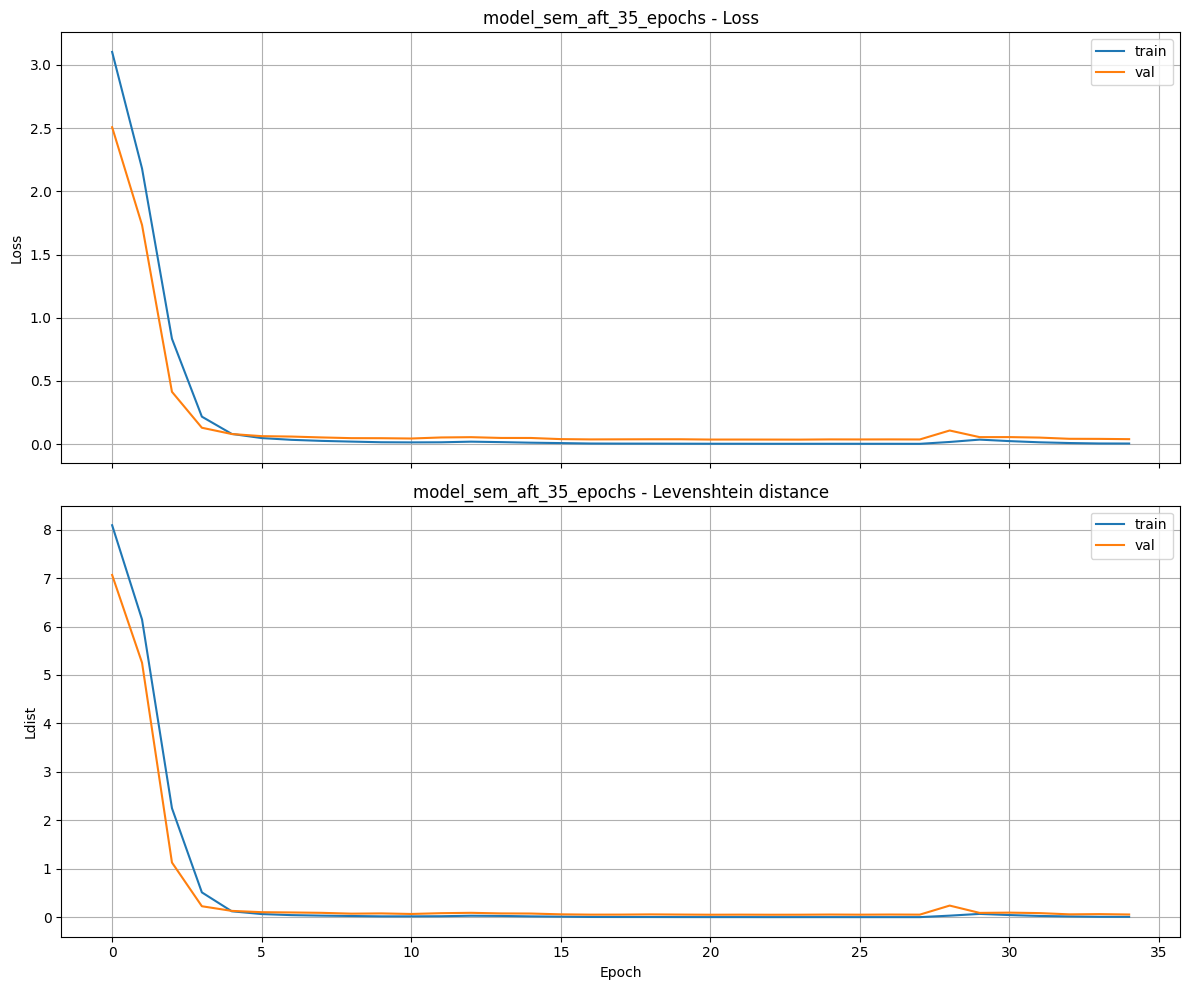

In [43]:
plot_losses_levendist(train_losses, val_losses, train_levenshtein_dists, val_levenshtein_dists, title="model_sem_aft_35_epochs")

### Формируем ответ для сабмита.

In [44]:
test_imgs = []

for i in range(10518):
    test_imgs.append({"file": os.path.join(PATH_TO_TEST, str(i) + '.png'),
                       "text": ""})

In [45]:
test_dataset = RecognitionDataset(test_imgs, transforms=transforms)
test_loader  = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False , num_workers=config["num_workers"], pin_memory=True, drop_last=False , collate_fn=collate_fn)

In [46]:
import pandas as pd

model.eval()

indices = []
labels = []

with torch.no_grad():
    for i, batch in enumerate(tqdm.tqdm(test_loader, total=len(test_loader), desc=f"epoch: {str(0).zfill(3)} | {'test':5}")):
        images = batch["torch_images"].to(device)

        seqs_pred = model(images).cpu()
        seqs_pred_str = decode(seqs_pred, abc)

        for idx in range(images.size(0)):
            indices.append(i * config["batch_size"] + idx)
            labels.append(seqs_pred_str[idx])

submission = pd.DataFrame({
    'index': indices,
    'label': labels
})

submission['label'] = submission['label'].apply(str)

submission.to_csv(os.path.join(AUX_DATA_ROOT, 'submission.csv'), index=False)
submission.to_csv('submission.csv', index=False)

epoch: 000 | test : 100%|██████████| 83/83 [00:25<00:00,  3.24it/s]


### Попробуем усложнить модель.

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="AIM_DL_HW4",
    name="CRNN_prelu",
    reinit=True,
    config=config
)

epoch,▁▁
epoch_levenshtein_dist_train,█▁
epoch_levenshtein_dist_val,▁█
epoch_loss_train,█▁
epoch_loss_val,▁█
loss,▂▂▁▃▁▁▁▂▁▃▂▄▂▁▃▂▄▃▃▂▆▅▁█▆▄▁▁▁▂▂▁▁▁▂▁▂▂▂▄
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_step,▁▁▁▁▁▂▂▂▃▃▄▄▄▄▅▅▆▆▇▇▇▇███▂▂▂▂▂▄▄▄▅▅▆▆▇▇█
epoch,9
epoch_levenshtein_dist_train,0.01619
epoch_levenshtein_dist_val,0.08717


In [ ]:
crnn      = ConvolutionalRecurrentNeuralNetwork(imgH, 3, hid_size, nclass, leakyRelu=False, PRelu=True)
optimizer = config["optimizer"](crnn.parameters(), lr=config["learning_rate"], amsgrad=True, weight_decay=config["weight_decay"])

In [ ]:
train_losses, val_losses, train_levenshtein_dists, val_levenshtein_dists, best_val_loss, model1 = run_experiment(
    crnn,
    train_loader,
    val_loader,
    optimizer,
    config["num_epochs"],
    device,
    os.path.join(AUX_DATA_ROOT, "checkpoints1"),
)

epoch: 000 | train: 100%|██████████| 153/153 [00:56<00:00,  2.69it/s]
epoch: 000 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints1/epoch=00_valloss=2.749.pth.tar



epoch: 001 | train: 100%|██████████| 153/153 [00:56<00:00,  2.69it/s]
epoch: 001 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.66it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints1/epoch=01_valloss=1.966.pth.tar



epoch: 002 | train:  88%|████████▊ | 134/153 [00:50<00:06,  2.87it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795b5f0195a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
epoch: 002 | train:  96%|█████████▌| 147/153 [00:55<00:01,  3.05it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795b5f0195a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/

New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints1/epoch=02_valloss=0.248.pth.tar



epoch: 003 | train:  33%|███▎      | 50/153 [00:18<00:32,  3.13it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795b5f0195a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
epoch: 003 | train:  47%|████▋     | 72/153 [00:26<00:30,  2.68it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x795b5f0195a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/lo

New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints1/epoch=03_valloss=0.097.pth.tar



epoch: 004 | train: 100%|██████████| 153/153 [00:57<00:00,  2.65it/s]
epoch: 004 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.41it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints1/epoch=04_valloss=0.080.pth.tar



epoch: 005 | train: 100%|██████████| 153/153 [00:56<00:00,  2.70it/s]
epoch: 005 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.40it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints1/epoch=05_valloss=0.059.pth.tar



epoch: 006 | train: 100%|██████████| 153/153 [01:00<00:00,  2.54it/s]
epoch: 006 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.79it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints1/epoch=06_valloss=0.058.pth.tar



epoch: 007 | train: 100%|██████████| 153/153 [00:54<00:00,  2.79it/s]
epoch: 007 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.72it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints1/epoch=07_valloss=0.052.pth.tar



epoch: 008 | train: 100%|██████████| 153/153 [00:58<00:00,  2.62it/s]
epoch: 008 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.31it/s]
epoch: 009 | train: 100%|██████████| 153/153 [00:54<00:00,  2.81it/s]
epoch: 009 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.41it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints1/epoch=09_valloss=0.051.pth.tar

Best val_loss = 0.051 reached at epoch 9


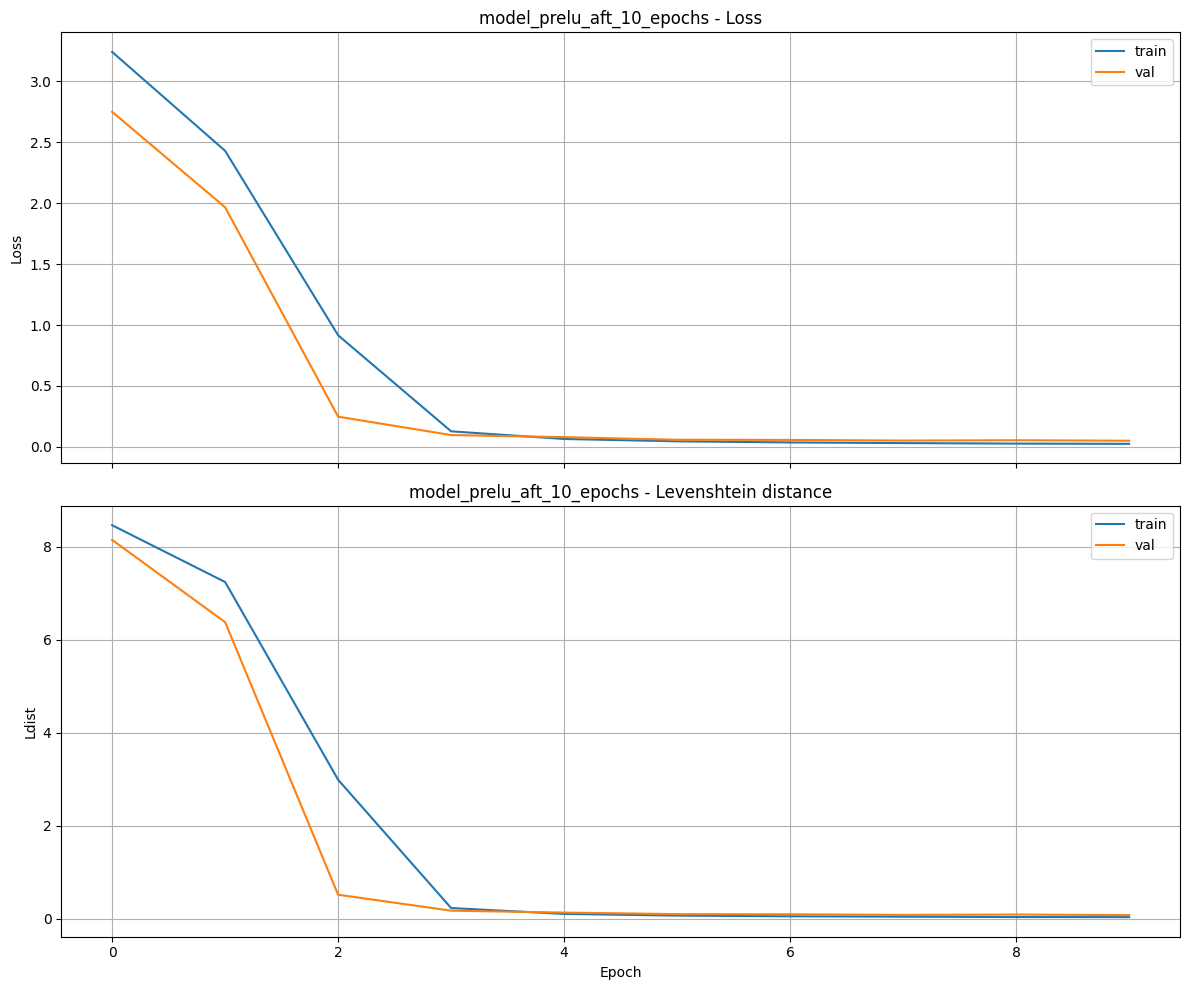

In [ ]:
plot_losses_levendist(train_losses, val_losses, train_levenshtein_dists, val_levenshtein_dists, title="model_prelu_aft_10_epochs")

In [86]:
import pandas as pd

model1.eval()

indices = []
labels = []

with torch.no_grad():
    for i, batch in enumerate(tqdm.tqdm(test_loader, total=len(test_loader), desc=f"epoch: {str(0).zfill(3)} | {'test':5}")):
        images = batch["torch_images"].to(device)

        seqs_pred = model1(images).cpu()
        seqs_pred_str = decode(seqs_pred, abc)

        for idx in range(images.size(0)):
            indices.append(i * config["batch_size"] + idx)
            labels.append(seqs_pred_str[idx])

submission = pd.DataFrame({
    'index': indices,
    'label': labels
})

submission['label'] = submission['label'].apply(str)

submission.to_csv('submission1.csv', index=False)

epoch: 000 | test : 100%|██████████| 83/83 [00:24<00:00,  3.40it/s]


### Попробуем LeakyReLU

In [87]:
wandb.init(
    # set the wandb project where this run will be logged
    project="AIM_DL_HW4",
    name="CRNN_leakyrelu",
    reinit=True,
    config=config
)

epoch,▁▂▃▃▄▅▆▆▇█
epoch_levenshtein_dist_train,█▇▃▁▁▁▁▁▁▁
epoch_levenshtein_dist_val,█▆▁▁▁▁▁▁▁▁
epoch_loss_train,█▆▃▁▁▁▁▁▁▁
epoch_loss_val,█▆▂▁▁▁▁▁▁▁
loss,████▇▇▆▅▅▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
epoch,9
epoch_levenshtein_dist_train,0.0362
epoch_levenshtein_dist_val,0.07902


In [88]:
crnn      = ConvolutionalRecurrentNeuralNetwork(imgH, n_layers, hid_size, nclass, leakyRelu=True, PRelu=False)
optimizer = config["optimizer"](crnn.parameters(), lr=config["learning_rate"], amsgrad=True, weight_decay=config["weight_decay"])

In [89]:
train_losses, val_losses, train_levenshtein_dists, val_levenshtein_dists, best_val_loss, model2 = run_experiment(
    crnn,
    train_loader,
    val_loader,
    optimizer,
    config["num_epochs"],
    device,
    os.path.join(AUX_DATA_ROOT, "checkpoints2"),
)

epoch: 000 | train: 100%|██████████| 153/153 [00:45<00:00,  3.37it/s]
epoch: 000 | val  : 100%|██████████| 39/39 [00:12<00:00,  3.16it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints2/epoch=00_valloss=2.489.pth.tar



epoch: 001 | train: 100%|██████████| 153/153 [00:42<00:00,  3.63it/s]
epoch: 001 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.47it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints2/epoch=01_valloss=1.734.pth.tar



epoch: 002 | train: 100%|██████████| 153/153 [00:41<00:00,  3.67it/s]
epoch: 002 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.30it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints2/epoch=02_valloss=0.356.pth.tar



epoch: 003 | train: 100%|██████████| 153/153 [00:45<00:00,  3.39it/s]
epoch: 003 | val  : 100%|██████████| 39/39 [00:08<00:00,  4.34it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints2/epoch=03_valloss=0.129.pth.tar



epoch: 004 | train: 100%|██████████| 153/153 [00:42<00:00,  3.62it/s]
epoch: 004 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.71it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints2/epoch=04_valloss=0.077.pth.tar



epoch: 005 | train: 100%|██████████| 153/153 [00:46<00:00,  3.31it/s]
epoch: 005 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.89it/s]
epoch: 006 | train: 100%|██████████| 153/153 [00:45<00:00,  3.33it/s]
epoch: 006 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.71it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints2/epoch=06_valloss=0.056.pth.tar



epoch: 007 | train: 100%|██████████| 153/153 [00:42<00:00,  3.60it/s]
epoch: 007 | val  : 100%|██████████| 39/39 [00:11<00:00,  3.33it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints2/epoch=07_valloss=0.054.pth.tar



epoch: 008 | train: 100%|██████████| 153/153 [00:48<00:00,  3.12it/s]
epoch: 008 | val  : 100%|██████████| 39/39 [00:12<00:00,  3.00it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints2/epoch=08_valloss=0.048.pth.tar



epoch: 009 | train: 100%|██████████| 153/153 [00:45<00:00,  3.35it/s]
epoch: 009 | val  : 100%|██████████| 39/39 [00:10<00:00,  3.70it/s]


New checkpoint saved to /content/drive/MyDrive/ML3_2024/HW4/checkpoints2/epoch=09_valloss=0.046.pth.tar

Best val_loss = 0.046 reached at epoch 9


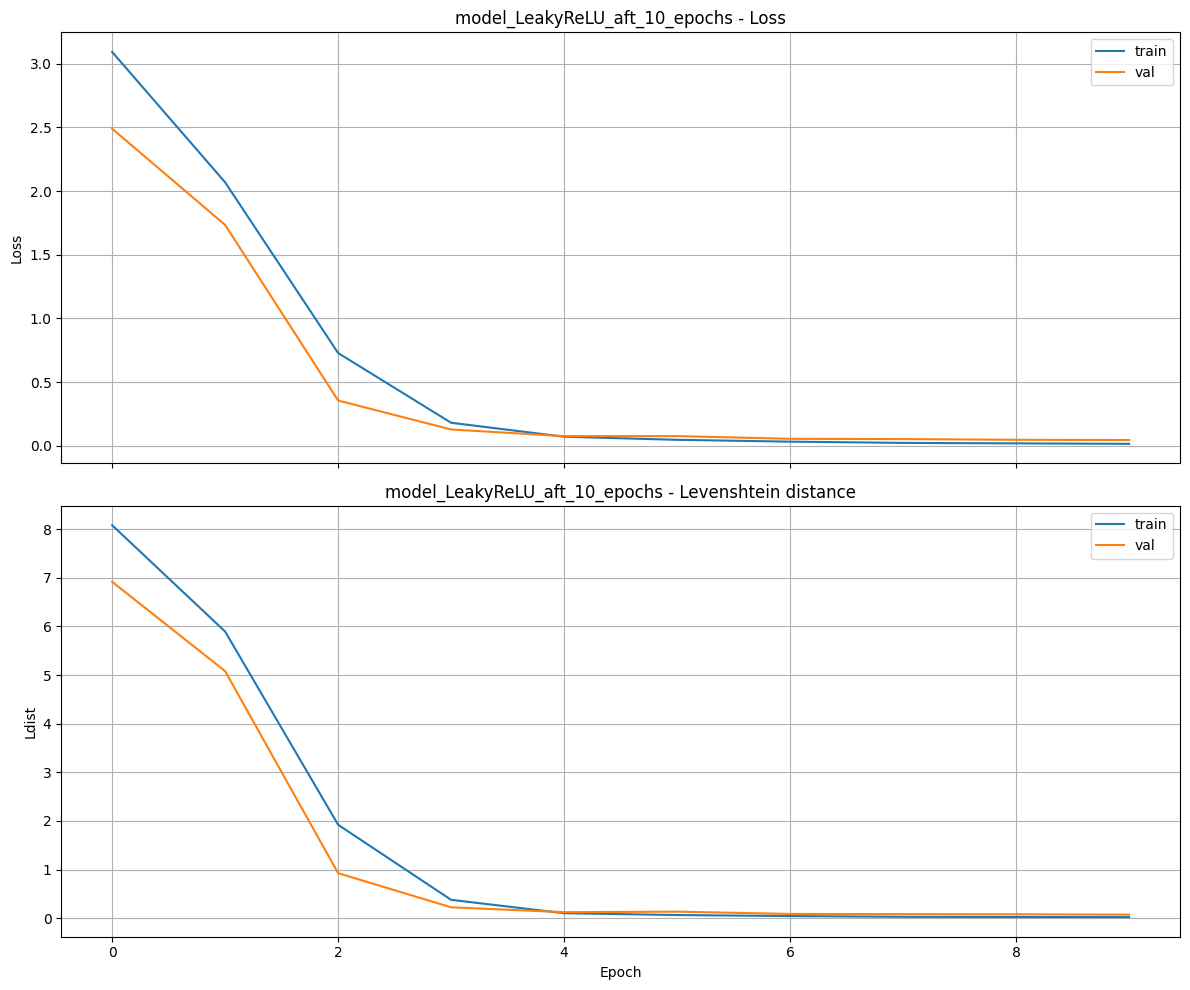

In [90]:
plot_losses_levendist(train_losses, val_losses, train_levenshtein_dists, val_levenshtein_dists, title="model_LeakyReLU_aft_10_epochs")

In [91]:
import pandas as pd

model2.eval()

indices = []
labels = []

with torch.no_grad():
    for i, batch in enumerate(tqdm.tqdm(test_loader, total=len(test_loader), desc=f"epoch: {str(0).zfill(3)} | {'test':5}")):
        images = batch["torch_images"].to(device)

        seqs_pred = model2(images).cpu()
        seqs_pred_str = decode(seqs_pred, abc)

        for idx in range(images.size(0)):
            indices.append(i * config["batch_size"] + idx)
            labels.append(seqs_pred_str[idx])

submission = pd.DataFrame({
    'index': indices,
    'label': labels
})

submission['label'] = submission['label'].apply(str)

submission.to_csv('submission2.csv', index=False)

epoch: 000 | test : 100%|██████████| 83/83 [00:30<00:00,  2.76it/s]
